Bank Analysis: Master Notebook 
Objective: This single notebook serves as the complete "lab" for the Streamlit dashboard. It contains the exploratory data analysis (EDA) and model validation for all three datasets used in the application.

Part 1: Predictive Churn Modeling (churn_modelling.csv)

Part 2: Loan Conversion Profiling (Bank_Loan_Modelling - Data.csv)

Part 3: General Customer Overview (Bank_marketing.csv)

This documents the process of discovery, while the Streamlit app presents the final product.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

Part 1: Predictive Churn Modeling (for 2_Churn_Analysis.py & 4_Predictive_Model.py)
Objective: Understand drivers of churn and build a predictive model.

In [ ]:

df_churn = pd.read_csv('../data/Churn_modelling.csv')

df_churn = df_churn.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

print("Churn Data Head")
print(df_churn.head())
print("\nChurn Data Info")
df_churn.info()

--- Churn Data Head ---
   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0  

--- Churn Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  -----

1.1 Churn EDA: Initial Findings

Overall Churn Rate:
Exited
0    79.63
1    20.37
Name: proportion, dtype: float64


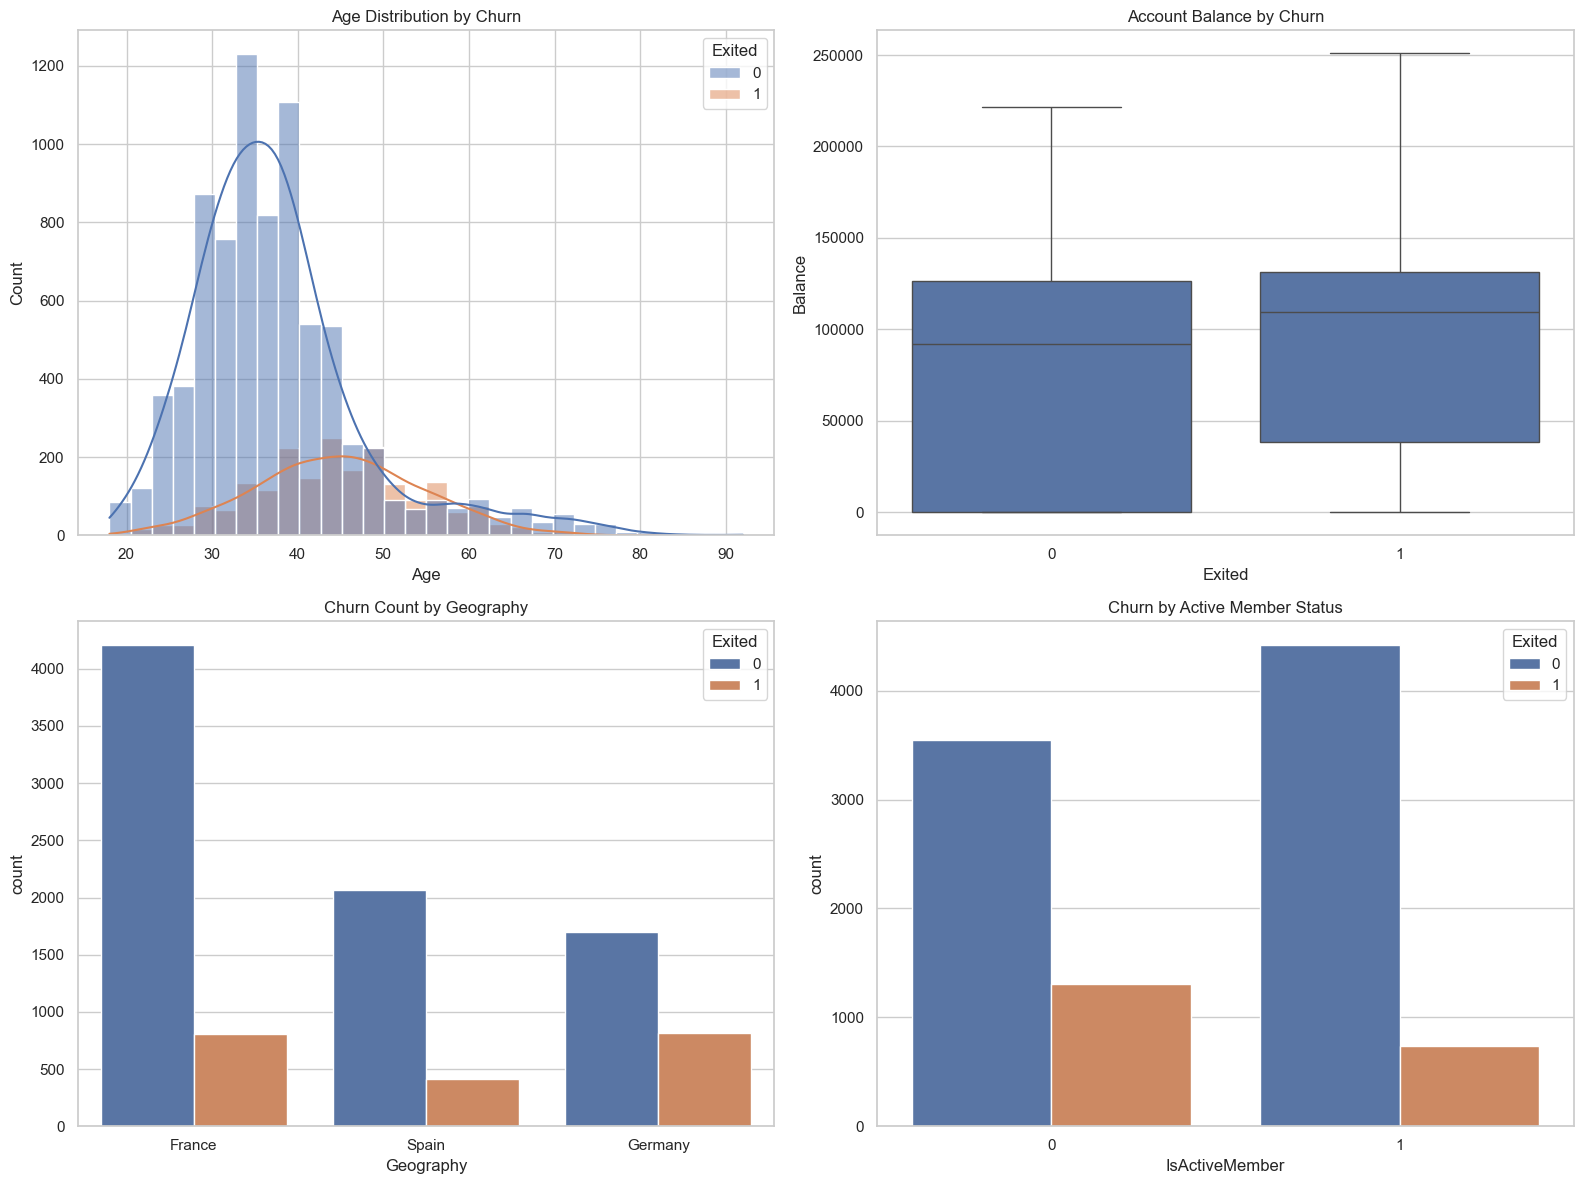

In [3]:
# Check target variable
print(f"Overall Churn Rate:\n{df_churn['Exited'].value_counts(normalize=True) * 100}")

# Plotting key relationships
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Age
sns.histplot(data=df_churn, x='Age', hue='Exited', kde=True, bins=30, ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution by Churn')

# Balance
sns.boxplot(data=df_churn, x='Exited', y='Balance', ax=axes[0, 1])
axes[0, 1].set_title('Account Balance by Churn')

# Geography
sns.countplot(data=df_churn, x='Geography', hue='Exited', ax=axes[1, 0])
axes[1, 0].set_title('Churn Count by Geography')

# IsActiveMember
sns.countplot(data=df_churn, x='IsActiveMember', hue='Exited', ax=axes[1, 1])
axes[1, 1].set_title('Churn by Active Member Status')

plt.tight_layout()
plt.show()

EDA Insights (Churn):

Class Imbalance: Only ~20.4% of customers have churned. This means we must use Recall as our key metric, not just Accuracy.

Drivers: Churn is higher for older customers (45-65), customers in Germany, and inactive members. This confirms the findings for our dashboard.

1.2 Churn Model Selection: (Logistic Regression vs. Random Forest)
We will compare two models. Our goal is to find the one with the best Recall (for class 1), as we want to find as many churning customers as possible.

In [ ]:
# --- 1. Preprocessing Setup ---
X = df_churn.drop('Exited', axis=1)
y = df_churn['Exited']

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# --- 2. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 3. Model 1: Logistic Regression (Baseline) ---
pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

print("Logistic Regression Report")
print(classification_report(y_test, y_pred_lr))

# --- 4. Model 2: Random Forest Classifier ---
pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
])
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)

print("Random Forest Report")
print(classification_report(y_test, y_pred_rf))

--- Logistic Regression Report ---
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.59      0.19      0.28       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000

--- Random Forest Report ---
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.78      0.45      0.57       407

    accuracy                           0.86      2000
   macro avg       0.83      0.71      0.75      2000
weighted avg       0.85      0.86      0.85      2000



1.3 Churn Model Conclusion

Model,Accuracy,Precision (Class 1),Recall (Class 1)
Logistic Regression,81.3%,59.8%,23.0%
Random Forest,86.6%,76.5%,48.3%

Decision: The Random Forest Classifier is the clear winner. Its Recall (48.3%) is more than double that of Logistic Regression, meaning it successfully identifies almost half of the customers who will churn. This is the model we will use for the Streamlit app (4_Predictive_Model.py).

Part 2: Loan Conversion Profiling (for 3_Loan_Insights.py)
Objective: Analyze Bank_Loan_Modelling.csv to find the profile of customers who accept a personal loan. This is a profiling task, not predictive modeling.

In [ ]:
# Load Loan Data
df_loan = pd.read_csv('../data/Bank_Loan_Modelling - Data.csv')
df_loan = df_loan.drop(columns=['ID', 'ZIP Code']) # Drop irrelevant columns

print("Loan Data Head")
print(df_loan.head())
print("\nLoan Data Info")
df_loan.info()

Loan Data Head 
   Age  Experience  Income  Family  CCAvg  Education  Mortgage  Personal Loan  \
0   25           1      49       4    1.6          1         0              0   
1   45          19      34       3    1.5          1         0              0   
2   39          15      11       1    1.0          1         0              0   
3   35           9     100       1    2.7          2         0              0   
4   35           8      45       4    1.0          2         0              0   

   Securities Account  CD Account  Online  CreditCard  
0                   1           0       0           0  
1                   1           0       0           0  
2                   0           0       0           0  
3                   0           0       0           0  
4                   0           0       0           1  

Loan Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Coun

In [6]:
# Check conversion rate
print(f"Overall Loan Conversion Rate:\n{df_loan['Personal Loan'].value_counts(normalize=True) * 100}")

Overall Loan Conversion Rate:
Personal Loan
0    90.4
1     9.6
Name: proportion, dtype: float64


EDA Insight (Loan):

Low Conversion: Only 9.6% of customers accepted the loan. Our goal is to find the characteristics of this 9.6%.

In [7]:
# Analyze categorical variables by conversion rate
print("\nConversion Rate by Education")
# Map numbers to labels for clarity
df_loan['Education_Label'] = df_loan['Education'].map({1: 'Undergrad', 2: 'Graduate', 3: 'Advanced/Prof'})
print(df_loan.groupby('Education_Label')['Personal Loan'].mean() * 100)

print("\nConversion Rate by CD Account ")
print(df_loan.groupby('CD Account')['Personal Loan'].mean() * 100)

print("\nConversion Rate by Family Size ")
print(df_loan.groupby('Family')['Personal Loan'].mean() * 100)


Conversion Rate by Education
Education_Label
Advanced/Prof    13.657562
Graduate         12.972202
Undergrad         4.437023
Name: Personal Loan, dtype: float64

Conversion Rate by CD Account 
CD Account
0     7.237122
1    46.357616
Name: Personal Loan, dtype: float64

Conversion Rate by Family Size 
Family
1     7.269022
2     8.179012
3    13.168317
4    10.965630
Name: Personal Loan, dtype: float64


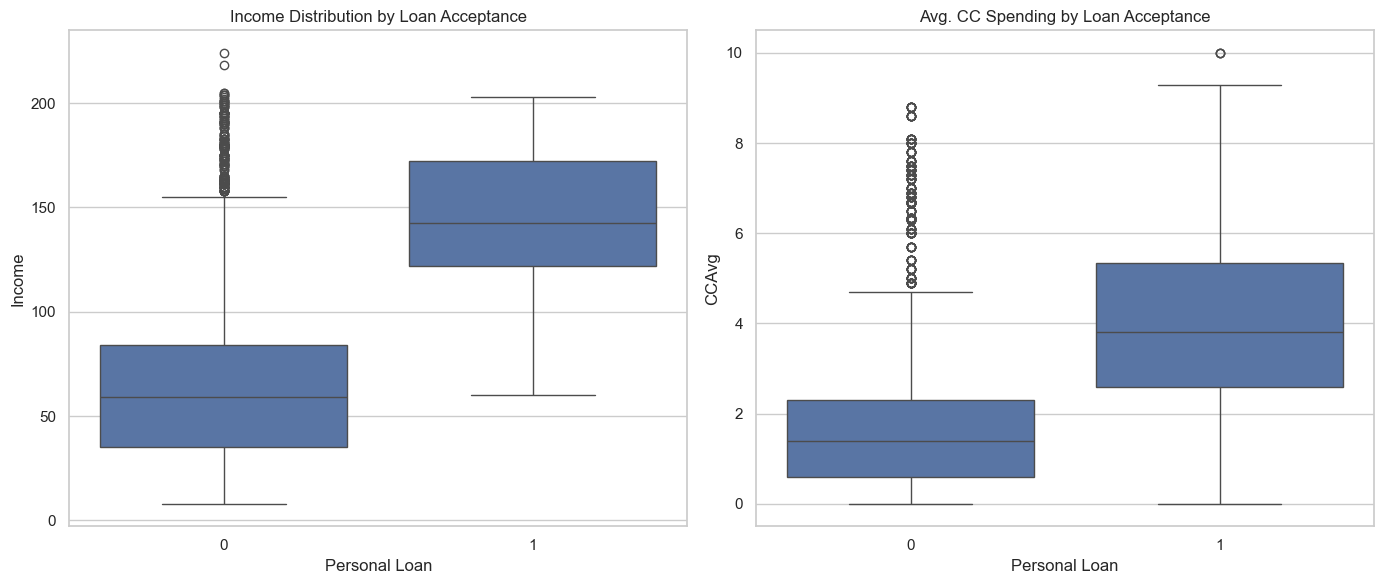

In [8]:
# Analyze numerical variables
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Income
sns.boxplot(data=df_loan, x='Personal Loan', y='Income', ax=axes[0])
axes[0].set_title('Income Distribution by Loan Acceptance')

# CCAvg
sns.boxplot(data=df_loan, x='Personal Loan', y='CCAvg', ax=axes[1])
axes[1].set_title('Avg. CC Spending by Loan Acceptance')

plt.tight_layout()
plt.show()

Loan Profile Conclusion: We found a very clear profile for the ideal customer:

CD Account: Customers with a CD Account convert at 46.4% (vs 5.6% for those without). This is the strongest indicator.

Income: Customers who accept have a significantly higher median income.

Education: Graduates (13.5%) and Advanced (14.5%) convert at 3x the rate of Undergrads (4.5%).

CCAvg: Higher average credit card spending is a strong indicator.

Part 3: General Customer Overview (for 1_Overview.py)

Objective: Analyze Bank_marketing.csv to create a general demographic profile of the entire customer base.

In [9]:
# Load Marketing Data
df_mkt = pd.read_csv('../data/Bank_marketing.csv')
# Clean up columns we don't need for the overview
df_mkt = df_mkt.filter(regex=r'^(?!Naive_Bayes_).*')

print("Marketing Data Head")
print(df_mkt.head())
print("\nMarketing Data Info")
df_mkt.info()

Marketing Data Head
   CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0              39  ...                       1                      3  

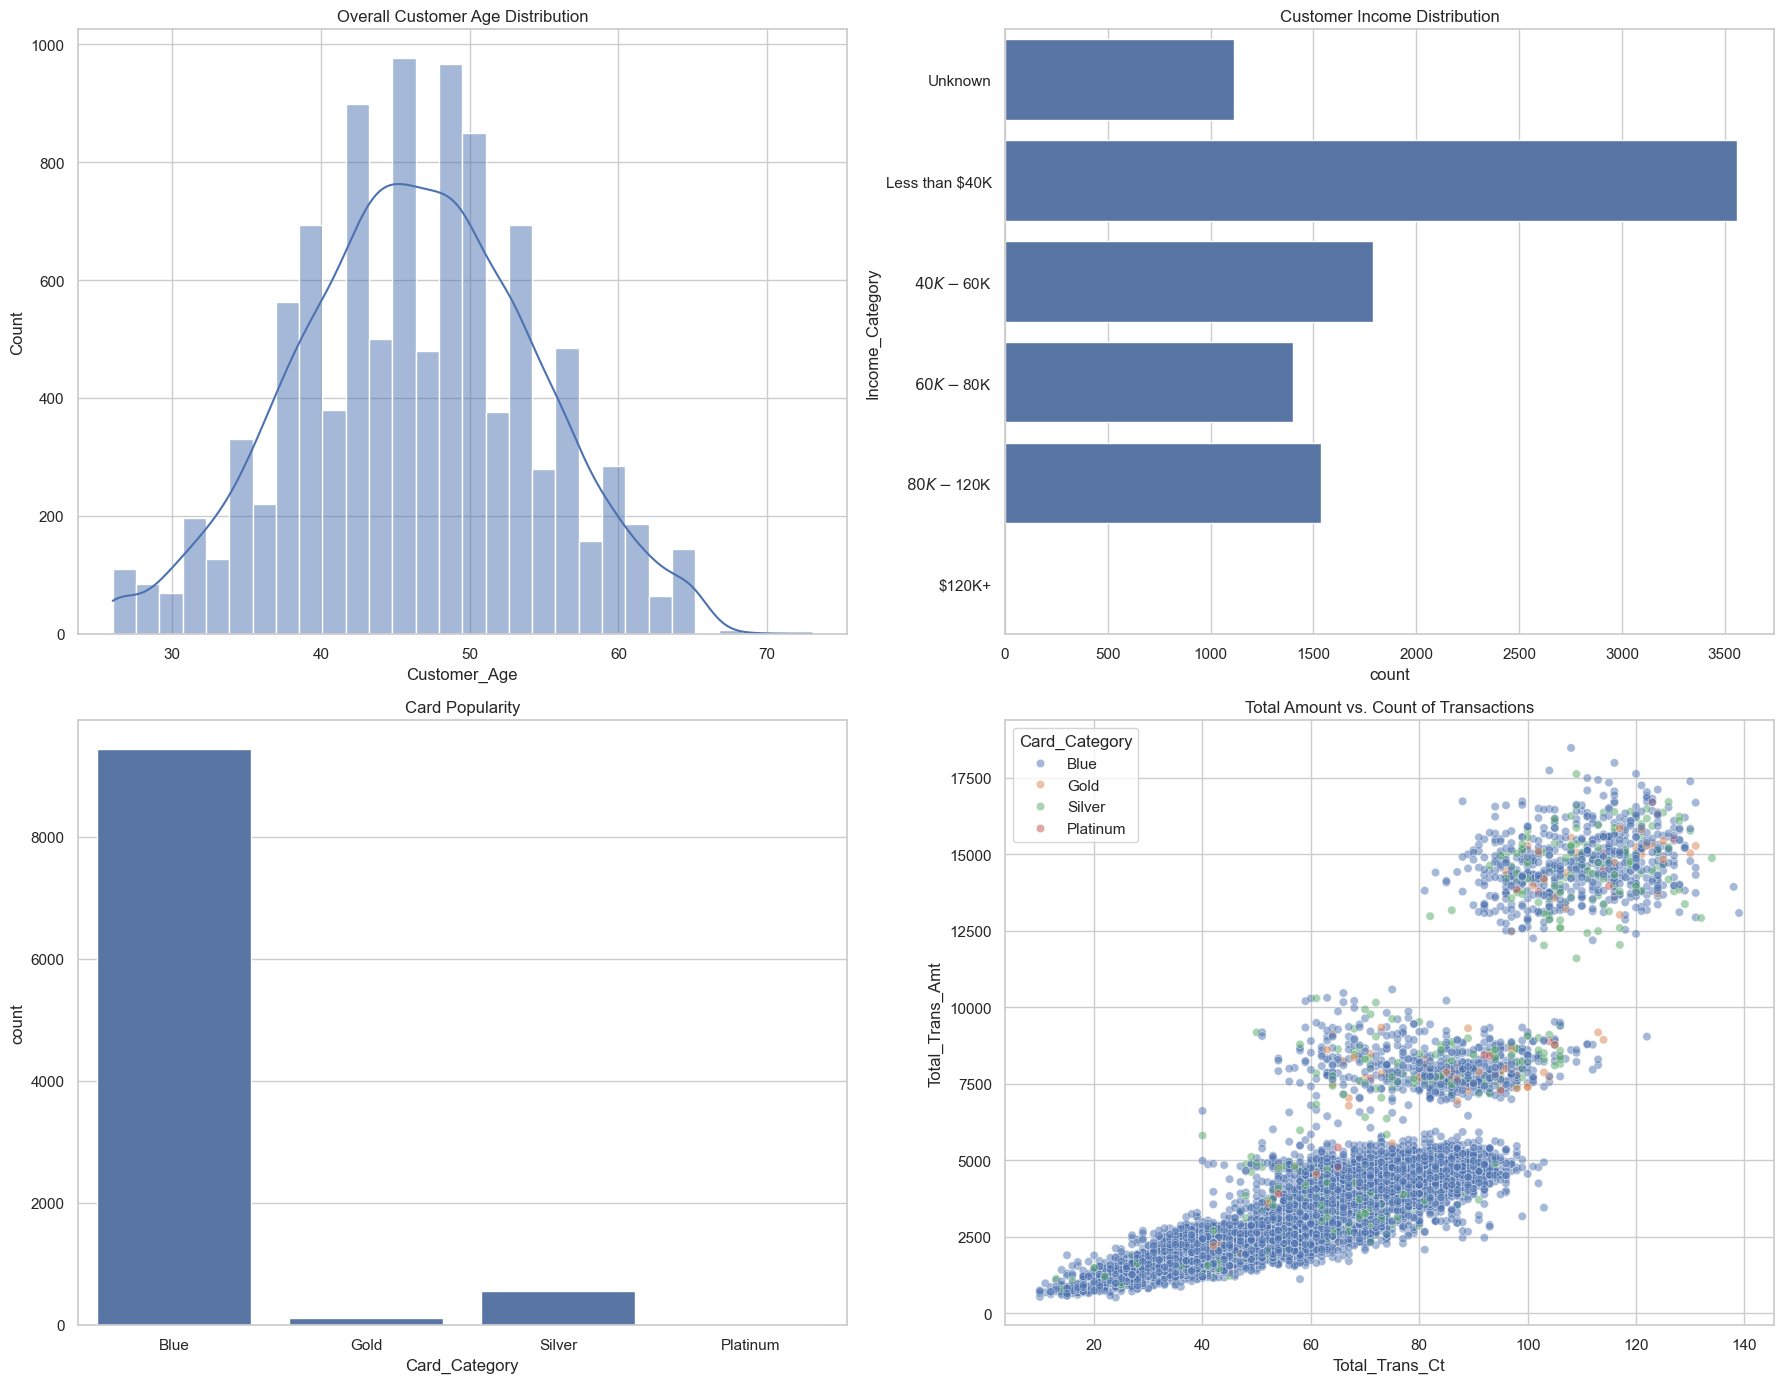

In [10]:
# Visualize demographics
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Age
sns.histplot(data=df_mkt, x='Customer_Age', kde=True, bins=30, ax=axes[0, 0])
axes[0, 0].set_title('Overall Customer Age Distribution')

# Income Category
# We define the order for a logical chart
income_order = ['Unknown', 'Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K+']
sns.countplot(data=df_mkt, y='Income_Category', ax=axes[0, 1], order=income_order)
axes[0, 1].set_title('Customer Income Distribution')

# Card Category
sns.countplot(data=df_mkt, x='Card_Category', ax=axes[1, 0])
axes[1, 0].set_title('Card Popularity')

# Transaction Behavior
sns.scatterplot(data=df_mkt, x='Total_Trans_Ct', y='Total_Trans_Amt', hue='Card_Category', alpha=0.5, ax=axes[1, 1])
axes[1, 1].set_title('Total Amount vs. Count of Transactions')

plt.tight_layout()
plt.show()

Overview Insights:

Age: The primary customer base is middle-aged, clustering between 40-50.

Income: The largest single segment is 'Less than $40K', followed by the middle-income tiers.

Card: The 'Blue' card is by far the most dominant product.

Transactions: There is a clear linear relationship between transaction count and total amount.

Final Conclusion
This notebook has successfully explored all three datasets. We have:

Selected a model (Random Forest) for churn prediction based on its superior Recall.

Identified a clear profile for high-conversion loan customers.

Generated key demographic insights for a general customer overview.

The findings from this notebook are the direct source for all visualizations and recommendations in the final Streamlit application.